## Task 3. Epipolar Geometry

Зробити 3 фотографії будівлі з різних ракурсів, таким чином, щоб на фотографіях було >= 8 спільних точкок. Знайти фундаментальні матриці і намалювати епіполярні прямі для кожної пари зображень.

In [1]:
import os
import cv2
import pickle
import matplotlib
import numpy as np
from numpy import *
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
mtx=pickle.load(open('mtx.pkl', 'rb'))
dist=pickle.load(open('dist.pkl', 'rb'))

#### Read and Undistort images

In [3]:
path_original="./original/" 
path_resized="./resized/"
path_undistorted="./resized_undistorted/"
resize_divide=4

images_original = [cv2.imread(f"{path_original}{image}", cv2.IMREAD_COLOR) for image in os.listdir(f'{path_original}')]

height, width, _ = images_original[0].shape
height = height // resize_divide
width = width // resize_divide
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (width,height), 1, (width,height))

#images = [cv2.resize(image, (width, height)) for image in images_original]

#undistorted = [cv2.undistort(image, mtx, dist, None, newcameramtx) for image in images]
#for i, image in enumerate(images):
#        cv2.imwrite(f"{path_resized}img{i}.png", image)
#for i, image in enumerate(undistorted):
#        cv2.imwrite(f"{path_undistorted}und{i}.png", image)

#read resized from the folder ./resized/
resized = [cv2.imread(f"{path_resized}{image}", cv2.IMREAD_COLOR) for image in os.listdir(f'{path_resized}')]
#read undistorted from the folder ./resized_undistorted/
images = [cv2.imread(f"{path_undistorted}{image}", cv2.IMREAD_COLOR) for image in os.listdir(f'{path_undistorted}')]

#### Implementation of 8-point algorithm

In [4]:

'''
This module is a transliteration of code originally written in MATLAB, 
Peter Kovesi, MATLAB functions for computer vision and image processing,
http://www.csse.uwa.edu.au/~pk
'''


def fundamental_matrix_eight_pts_algorithm(x1, x2):
    if (x1.shape==x2.shape):
        npts = max(x1.shape)
        x1 = r_[x1.T, ones((1,npts))]
        x2 = r_[x2.T, ones((1,npts))]
        
        # perform the normalization (translation and scaling)
        x1, T1 = normalize2dpts(x1);
        x2, T2 = normalize2dpts(x2);
        
        # assemble the constraint matrix
        A = c_[x2[0]*x1[0], x2[0]*x1[1], x2[0], x2[1]*x1[0], x2[1]*x1[1], x2[1], x1[0], x1[1], ones((npts,1))]
        
        # A*vec(F) = 0 implies that the fundamental matrix F can be extracted from
        # singular vector of V corresponding to smallest singular value
        (U, S, V) = linalg.svd(A)
        V = V.conj().T;
        F = V[:,8].reshape(3,3).copy()

        # the lower-rank approximation of F to be of rank 2,  by svd
        (U,D,V) = linalg.svd(F);
        F = dot(dot(U,diag([D[0], D[1], 0])),V);

        # denormalize
        F = dot(dot(T2.T,F),T1);
        return F


def normalize2dpts(pts):
    ''' This function translates and scales the input (homogeneous) points
    such that the output points are centered at origin and the mean distance
    from the origin is sqrt(2). As shown in Hartley (1997), this normalization
    process typically improves the condition number of the linear systems used
    for solving homographies, fundamental matrices, etc.
    References:
        Richard Hartley, PAMI 1997
        Peter Kovesi, MATLAB functions for computer vision and image processing,
        http://www.csse.uwa.edu.au/~pk
     '''
    
    # Centroid of finite points
    c = [mean(pts[0]), mean(pts[1])]

    # Shift origin to centroid.
    newp0 = pts[0]-c[0]
    newp1 = pts[1]-c[1]

    meandist = mean(sqrt(newp0**2 + newp1**2));

    scale = sqrt(2)/meandist;
    '''
    T = [scale   0   -scale*c(1)
         0     scale -scale*c(2)
         0       0      1      ];
    '''
    T = eye(3)
    T[0][0] = scale
    T[1][1] = scale
    T[0][2] = -scale*c[0]
    T[1][2] = -scale*c[1]
    newpts = dot(T, pts)

    return newpts, T


#### Image points

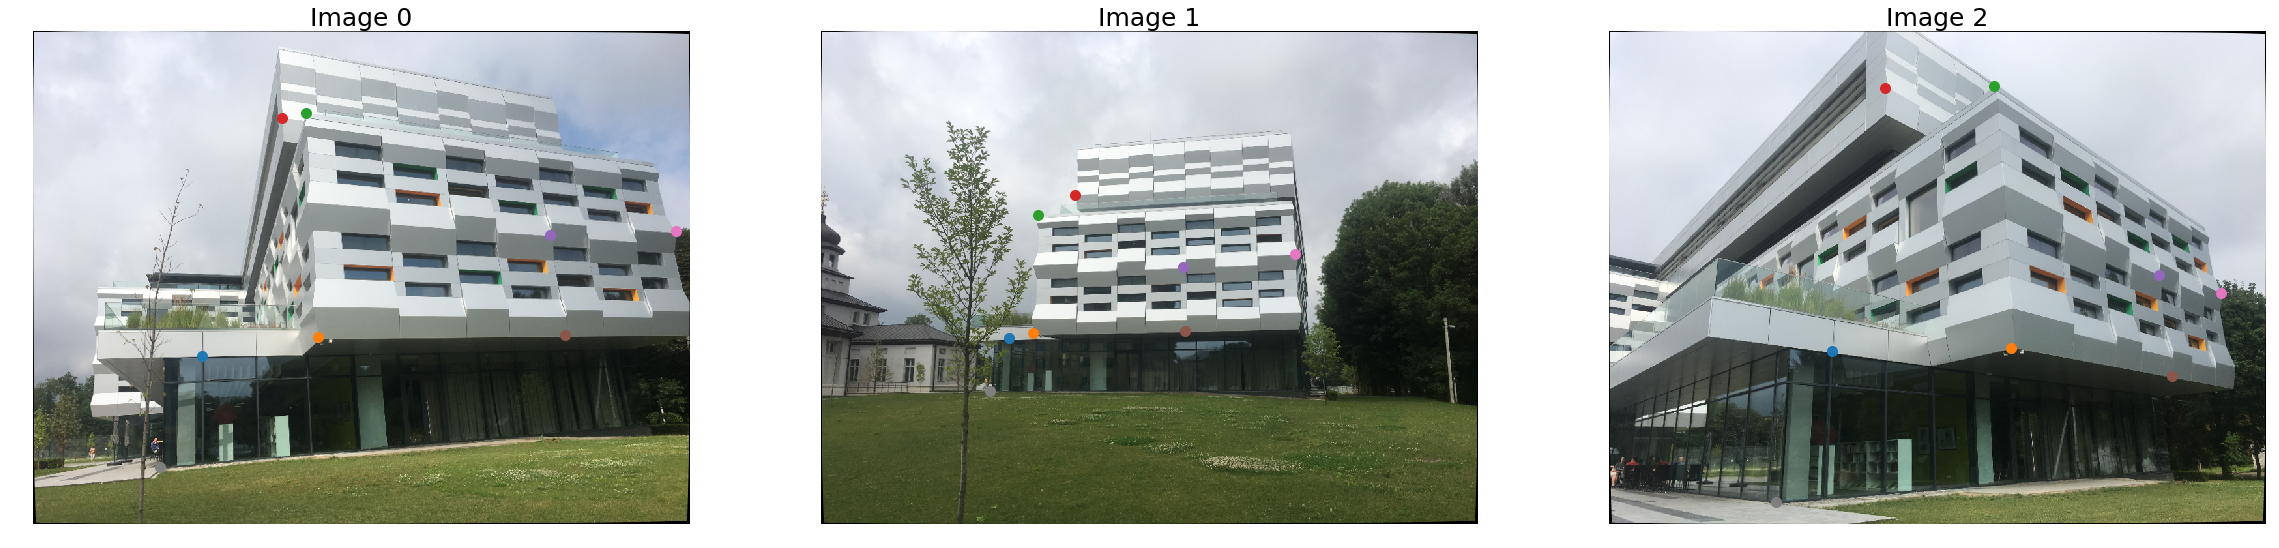

In [5]:
plt.figure(figsize=(40, 60))
plt.subplot(131)
plt.title(f'Image 0', fontsize=25)
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.scatter([259], [498], s=100)
plt.scatter([437], [469], s=100)
plt.scatter([418], [125], s=100)
plt.scatter([381], [132], s=100)
plt.scatter([793], [312], s=100)
plt.scatter([816], [466], s=100)
plt.scatter([987], [306], s=100)
plt.scatter([195], [669], s=100)
plt.axis('off')
plt.subplot(132)
plt.title(f'Image 1', fontsize=25)
plt.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
plt.scatter([289], [470], s=100)
plt.scatter([326], [463], s=100)
plt.scatter([333], [281], s=100)
plt.scatter([390], [251], s=100)
plt.scatter([555], [361], s=100)
plt.scatter([558], [459], s=100)
plt.scatter([728], [341], s=100)
plt.scatter([260], [551], s=100)
plt.axis('off')
plt.subplot(133)
plt.title(f'Image 2', fontsize=25)
plt.imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))
plt.scatter([342], [490], s=100)
plt.scatter([617], [486], s=100)
plt.scatter([591], [84], s=100)
plt.scatter([424], [87], s=100)
plt.scatter([845], [373], s=100)
plt.scatter([864], [529], s=100)
plt.scatter([940], [401], s=100)
plt.scatter([256], [722], s=100)
plt.axis('off')
plt.show()

In [6]:
points = {
    0: [(259, 498),
        (437, 469),
        (418, 125),
        (381, 132),
        (793, 312),
        (816, 466),
        (987, 306),
        (195, 669)
    ],
    1: [
        (289, 470),
        (326, 463),
        (333, 281),
        (390, 251),
        (555, 361),
        (558, 459),
        (728, 341),
        (260, 551)
    ],
    2: [
        (342, 490),
        (617, 486),
        (591, 84),
        (424, 87),
        (845, 373),
        (864, 529),
        (940, 401),
        (256, 722)
    ]}

### Show results

In [7]:
def drawlines(img1, img2, lines, pts1, pts2):
    r, c, _ = img1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 2)
        img1 = cv2.circle(img1, tuple(pt1), 8, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 8, color, -1)
    return img1,img2

In [8]:
def task_3(i,j):
    
    image1 = images[i].copy()
    image2 = images[j].copy()
    
    pts1 = np.int32(points[i])
    pts2 = np.int32(points[j])
    
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
    F2= fundamental_matrix_eight_pts_algorithm(pts1, pts2)
    
    print('\nFundamental matrix computed by OpenCV (cv2.findFundamentalMat):')
    print(F)
    print('\nEpipolar lines (fundamental matrix computed by OpenCV):')
    
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    left_with_lines, _ = drawlines(image1, image2, lines1, pts1, pts2)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    right_with_lines, _ = drawlines(image2, image1, lines2, pts2, pts1)

    plt.figure(figsize=(20, 30))
    plt.subplot(121)
    plt.title(f'Epipolar lines images {i}_{j}', fontsize=16)
    plt.imshow(cv2.cvtColor(left_with_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(122)
    plt.title(f'Epipolar lines images {j}_{i}', fontsize=16)
    plt.imshow(cv2.cvtColor(right_with_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    #plt.suptitle('Epipolar lines (fundamental matrix computed by OpenCV)', fontsize=16)
    plt.show()
    
    print('\n\nFundamental matrix computed by my method (fundamental_matrix_eight_pts_algorithm):')
    print(F2)
    print('\nEpipolar lines (fundamental matrix computed by my function):')

    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F2)
    lines1 = lines1.reshape(-1,3)
    left_with_lines, _ = drawlines(image1, image2, lines1, pts1, pts2)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F2)
    lines2 = lines2.reshape(-1,3)
    right_with_lines, _ = drawlines(image2, image1, lines2, pts2, pts1)
    
    plt.figure(figsize=(20, 30))
    #plt.suptitle('Epipolar lines (fundamental matrix computed by my function)', fontsize=16)
    plt.subplot(221)
    plt.title(f'Epipolar lines images {i}_{j}', fontsize=16)
    plt.imshow(cv2.cvtColor(left_with_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(222)
    plt.title(f'Epipolar lines images {j}_{i}', fontsize=16)
    plt.imshow(cv2.cvtColor(right_with_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

#### Images 0 and 1


Fundamental matrix computed by OpenCV (cv2.findFundamentalMat):
[[ 2.66419955e-07  2.83846683e-06 -2.00726262e-03]
 [-1.14720262e-06 -2.64984186e-07 -2.62929521e-03]
 [ 7.03797317e-04  8.12857939e-04  1.00000000e+00]]

Epipolar lines (fundamental matrix computed by OpenCV):


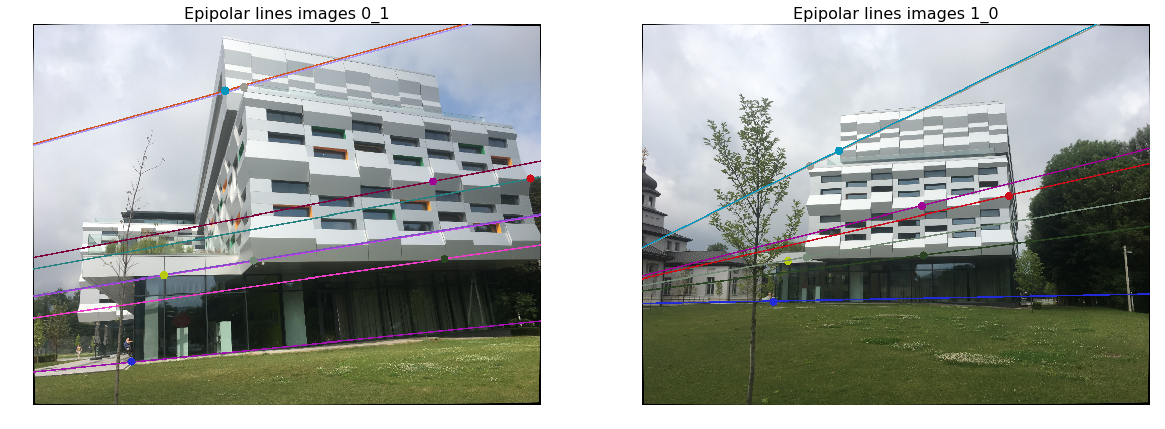



Fundamental matrix computed by my method (fundamental_matrix_eight_pts_algorithm):
[[ 4.38854883e-07  4.67560708e-06 -3.30642275e-03]
 [-1.88970632e-06 -4.36489841e-07 -4.33105335e-03]
 [ 1.15931590e-03  1.33896380e-03  1.64722978e+00]]

Epipolar lines (fundamental matrix computed by my function):


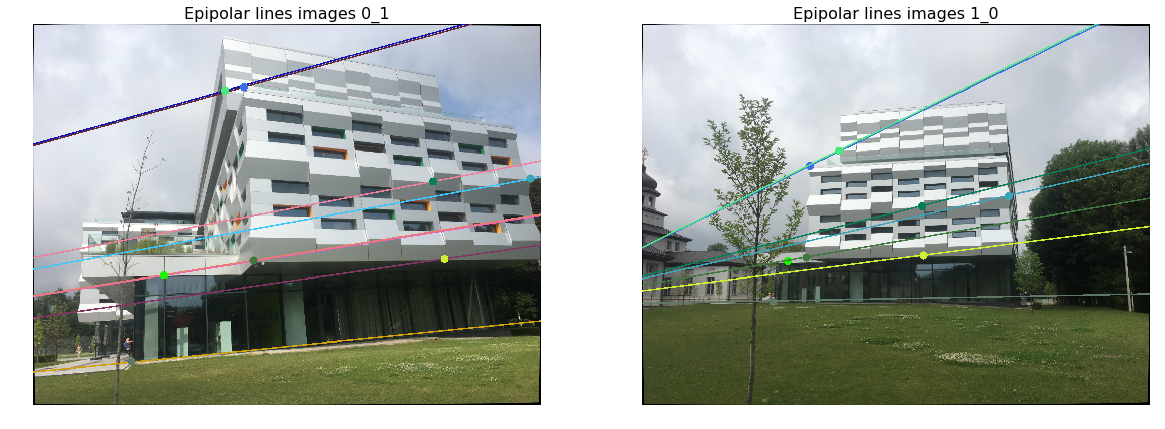

In [9]:
task_3(0,1)

#### Images 0 and 2


Fundamental matrix computed by OpenCV (cv2.findFundamentalMat):
[[-8.46223549e-07 -3.13583795e-06  1.01601992e-03]
 [ 5.80151701e-06 -1.07043994e-06  4.30347357e-03]
 [-2.51275453e-03 -5.27206243e-03  1.00000000e+00]]

Epipolar lines (fundamental matrix computed by OpenCV):


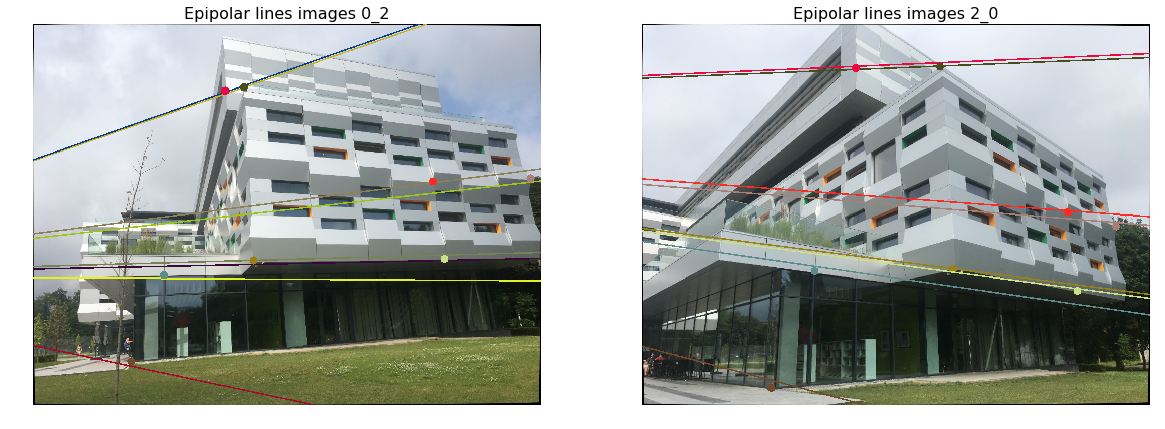



Fundamental matrix computed by my method (fundamental_matrix_eight_pts_algorithm):
[[-3.75214878e-07 -1.39042817e-06  4.50502462e-04]
 [ 2.57238823e-06 -4.74632258e-07  1.90815691e-03]
 [-1.11415345e-03 -2.33762848e-03  4.43399240e-01]]

Epipolar lines (fundamental matrix computed by my function):


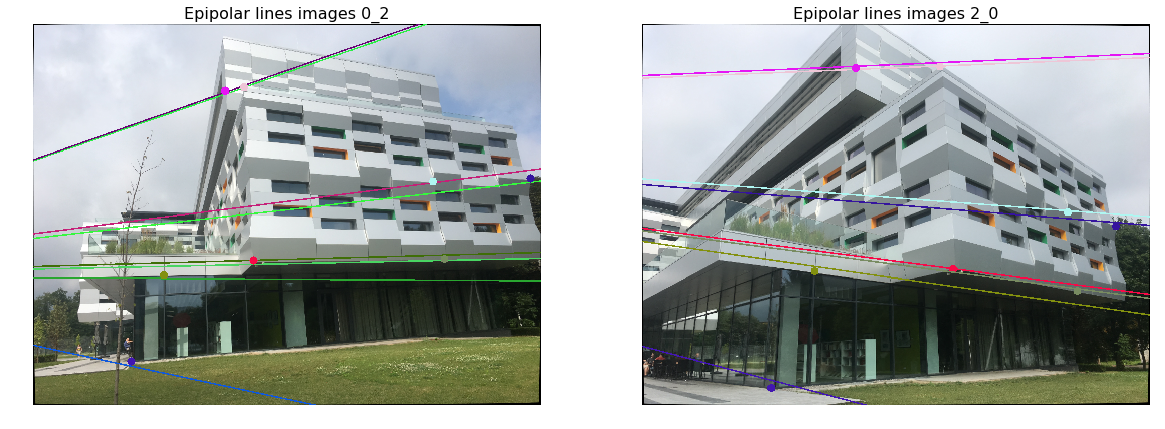

In [10]:
task_3(0,2)

#### Images 1 and 2


Fundamental matrix computed by OpenCV (cv2.findFundamentalMat):
[[-9.01817258e-08 -2.05082509e-07  9.64548357e-05]
 [ 2.48727298e-06 -5.04466081e-07  4.78290504e-04]
 [-1.44280301e-03 -2.21489209e-03  1.00000000e+00]]

Epipolar lines (fundamental matrix computed by OpenCV):


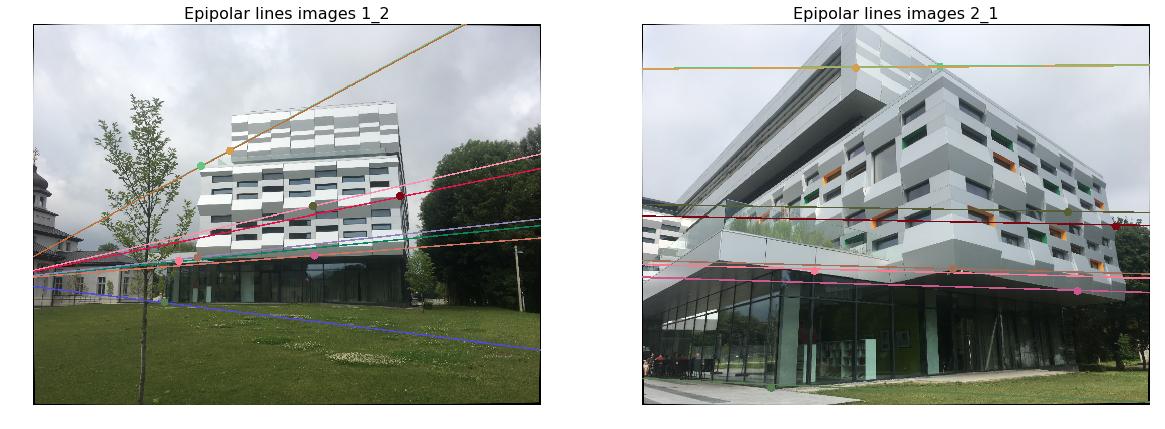



Fundamental matrix computed by my method (fundamental_matrix_eight_pts_algorithm):
[[ 2.08869674e-07  4.74991097e-07 -2.23398808e-04]
 [-5.76076685e-06  1.16839265e-06 -1.10776746e-03]
 [ 3.34167251e-03  5.12990612e-03 -2.31609755e+00]]

Epipolar lines (fundamental matrix computed by my function):


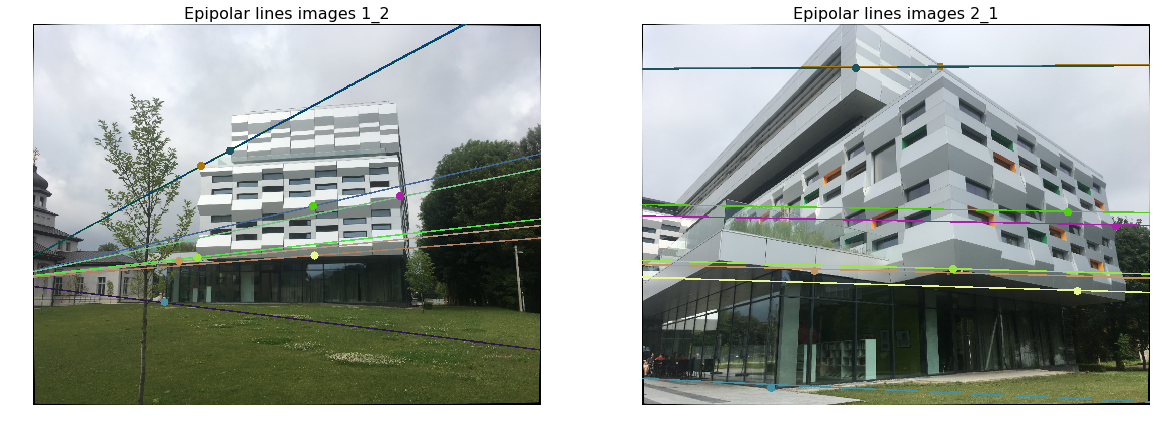

In [11]:
task_3(1,2)